In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from holisticai.datasets import load_adult
from holisticai.explainability import Explainer
from holisticai.efficacy.metrics import classification_efficacy_metrics

In [3]:
from holisticai.datasets import load_adult

# Dataset
dataset = load_adult()

# Dataframe
df = pd.concat([dataset["data"], dataset["target"]], axis=1)
protected_variables = ["sex", "race"]
output_variable = ["class"]

# Simple preprocessing
y = df[output_variable].replace({">50K": 1, "<=50K": 0})
X = pd.get_dummies(df.drop(protected_variables + output_variable, axis=1))
group = ["sex"]
group_a = df[group] == "Female"
group_b = df[group] == "Male"
data = [X, y, group_a, group_b]

# Train test split
dataset = train_test_split(*data, test_size=0.2, shuffle=True)
train_data = dataset[::2]
test_data = dataset[1::2]

In [4]:
#X.hist(bins=10, figsize=(10, 10), color = 'mediumslateblue')

<Axes: >

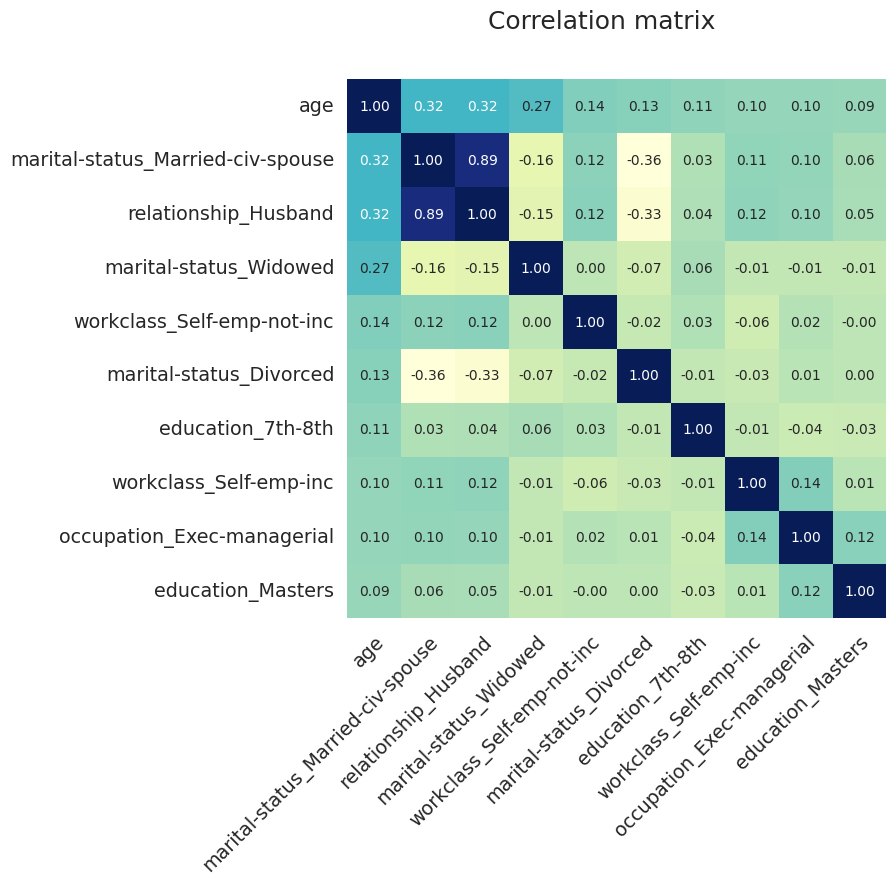

In [5]:
from holisticai.bias.plots import correlation_matrix_plot

correlation_matrix_plot(X, target_feature='age', size = (12,7))

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
seed = np.random.seed(42) # set seed for reproducibility
# simple preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed) # train test split


model = LogisticRegression() # instantiate model
model.fit(X_train, y_train) # fit model

y_pred = model.predict(X_test) # compute predictions

# compute efficacy metrics
classification_efficacy_metrics(y_test, y_pred)

,Value,Reference
Metric,,
Accuracy,0.803665,1
Balanced Accuracy,0.618640,1
Precision,0.714781,1
Recall,0.270306,1
F1-Score,0.392269,1


# Global Explainability Metrics (based on Permutation Feature Importance)

In [7]:
# permutation feature importance
permutation_explainer = Explainer(based_on='feature_importance',
                      strategy_type='permutation',
                      model_type='binary_classification',
                      model = model, 
                      x = X, 
                      y = y)

In [8]:
permutation_explainer.metrics()

,Value,Reference
Fourth Fifths,0.683673,0
Importance Spread Divergence,0.781118,-
Importance Spread Ratio,0.829635,0
Global Overlap Score,0.081298,1
Global Range Overlap Score,0.886508,1
Global Similarity Score,0.651632,1
Global Explainability Ease Score,1.000000,1


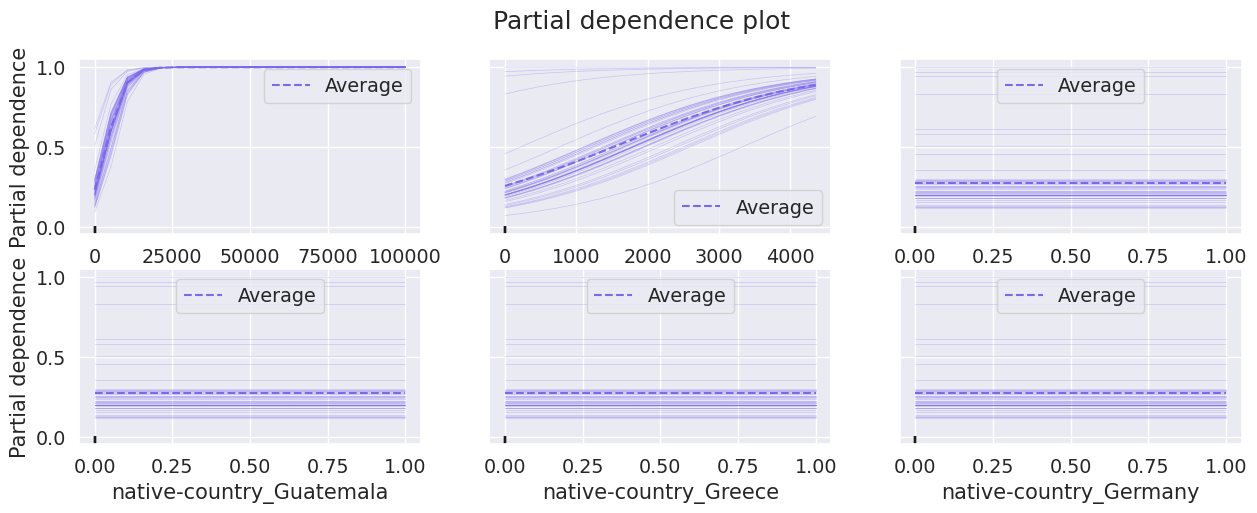

In [9]:
_,ax = plt.subplots(figsize=(15,5))
permutation_explainer.partial_dependence_plot(last=6, ax=ax, kind='both')

In [10]:
permutation_explainer.metrics(detailed=True)

,Value,Reference
Fourth Fifths,0.683673,0
Importance Spread Divergence,0.781118,-
Importance Spread Ratio,0.829635,0
Global Overlap Score [label=0],0.000000,1
Global Overlap Score [label=1],0.162596,1
Global Range Overlap Score [label=0],0.837564,1
Global Range Overlap Score [label=1],0.935452,1
Global Similarity Score [label=0],0.661949,1
Global Similarity Score [label=1],0.641314,1
Global Explainability Ease Score,1.000000,1


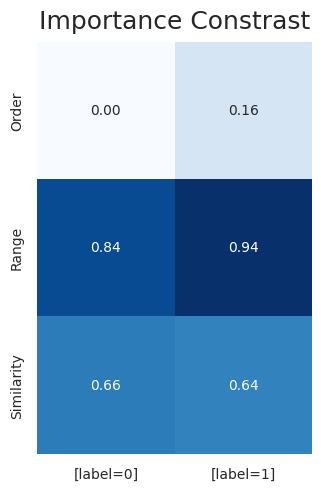

In [11]:
# Contrast Whole Importance vs. Group Importance
# -> Order -> mean positions
# -> Range -> match range of position 
# -> Similarity -> compute similarity
# -> e.g. we can see that Q0-Q1 and Q2-Q3 strong changes in their position but their importance weights maintains a high similarity with the whole model.
# -> e.g. we can see that Q1-Q2 and Q3-Q4 small changes in their position and their importance weights maintains a high similarity with the whole model.
permutation_explainer.contrast_visualization(show_connections=False)
# TODO separate show connections sin a second matrix

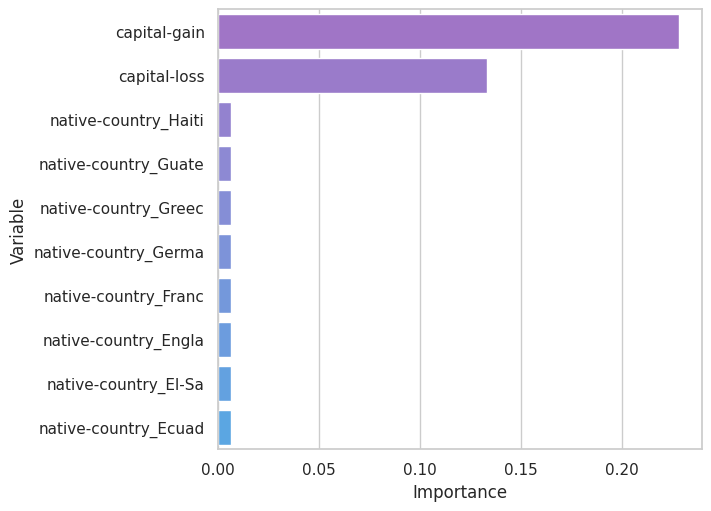

In [12]:
permutation_explainer.bar_plot(max_display=10)

In [13]:
permutation_explainer.feature_importance_table(sorted_by='Global', top_n=5)

,Global Importance,[label=0] Importance,[label=1] Importance
Variable,,,
capital-gain,0.228271,0.053770,0.041040
capital-loss,0.133257,0.029886,0.022895
workclass_Local-gov,0.006727,0.008954,0.009935
workclass_Never-worked,0.006727,0.008954,0.009935
native-country_Yugoslavia,0.006727,0.008954,0.009935


In [14]:
# surrogate feature importance
surrogate_explainer = Explainer(based_on='feature_importance',
                      strategy_type='surrogate',
                      model_type='binary_classification',
                      model = model, 
                      x = X, 
                      y = y)

In [15]:
surrogate_explainer.metrics()

,Value,Reference
Fourth Fifths,0.010204,0
Importance Spread Divergence,3.768813,-
Importance Spread Ratio,0.178007,0
Global Explainability Ease Score,1.000000,1
Surrogate Efficacy Classification,0.799394,1


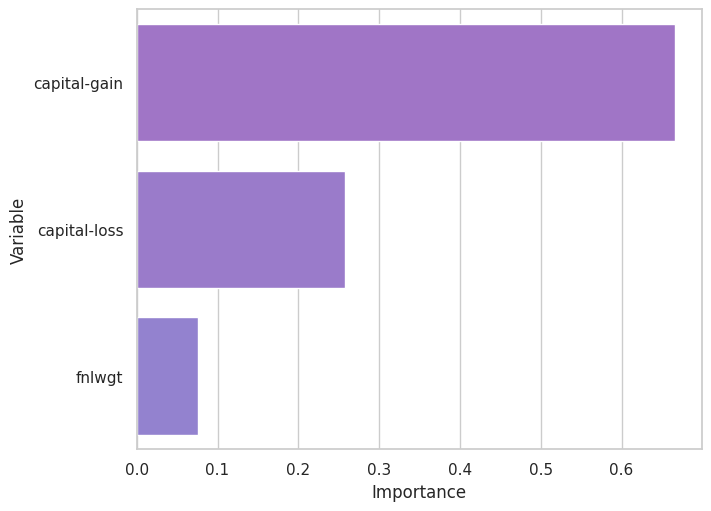

In [16]:
surrogate_explainer.bar_plot(max_display=3)

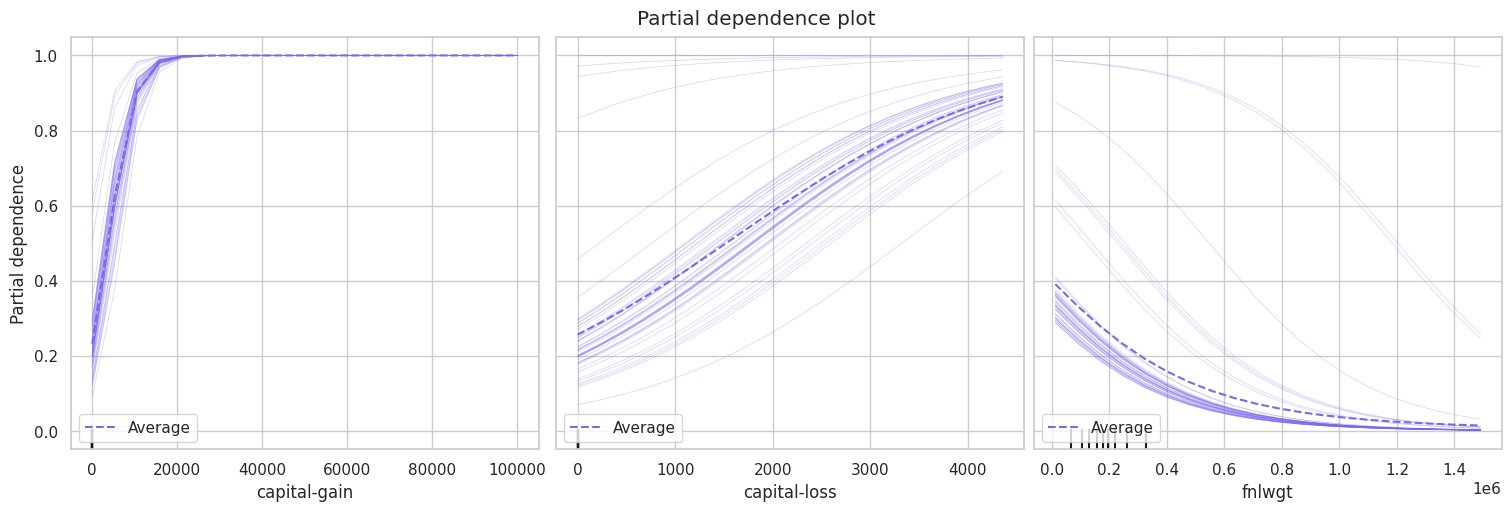

In [17]:
_,ax = plt.subplots(figsize=(15,5))
surrogate_explainer.partial_dependence_plot(last=3, ax=ax, kind='both')

In [18]:
surrogate_explainer.feature_importance_table(sorted_by='Global', top_n=10)

,Global Importance
Variable,
capital-gain,0.665819
capital-loss,0.258274
fnlwgt,0.075907
native-country_Yugoslavia,0.000000
age,0.000000
education-num,0.000000
hours-per-week,0.000000
workclass_Federal-gov,0.000000
workclass_Local-gov,0.000000


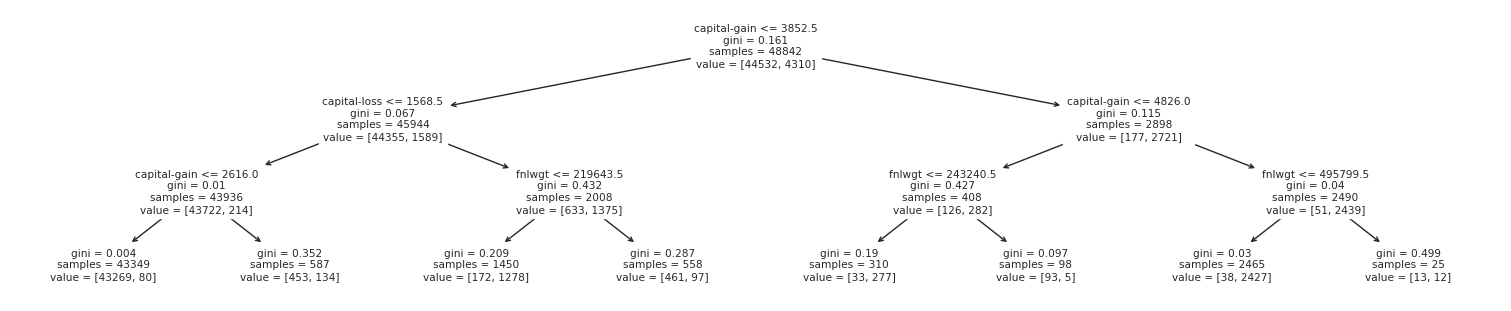

In [19]:
_,ax = plt.subplots(figsize=(15,3))
_ = surrogate_explainer.tree_visualization('sklearn', ax=ax)

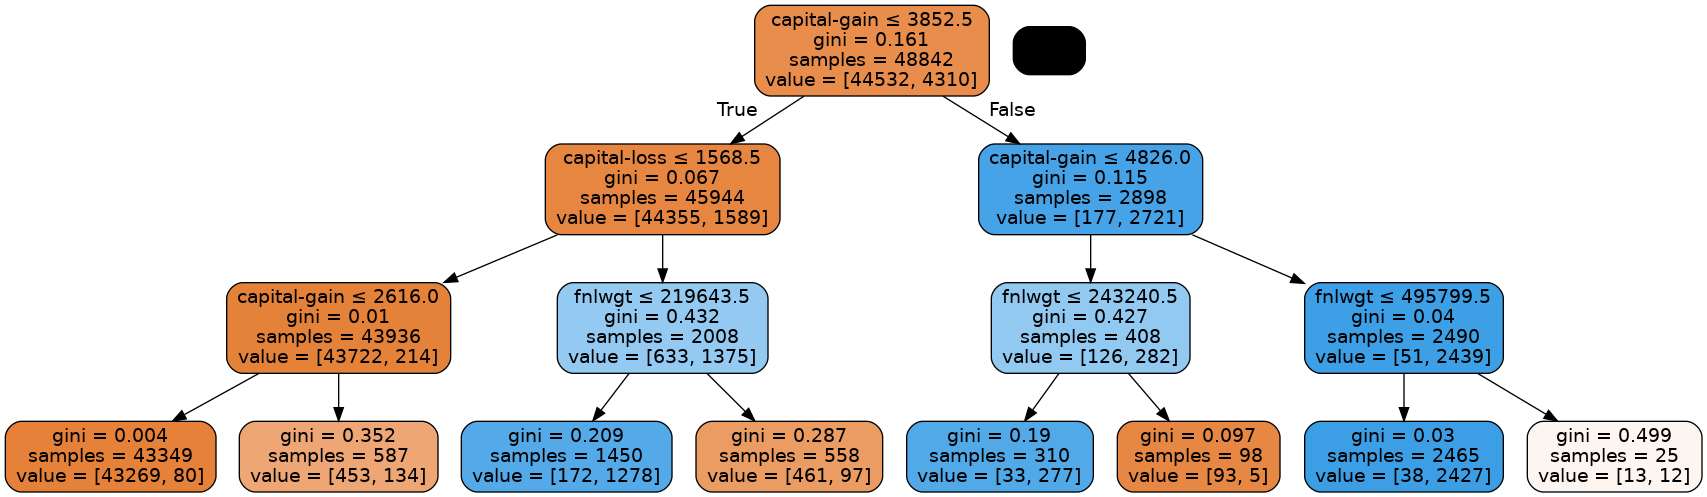

In [20]:
surrogate_explainer.tree_visualization('pydotplus')

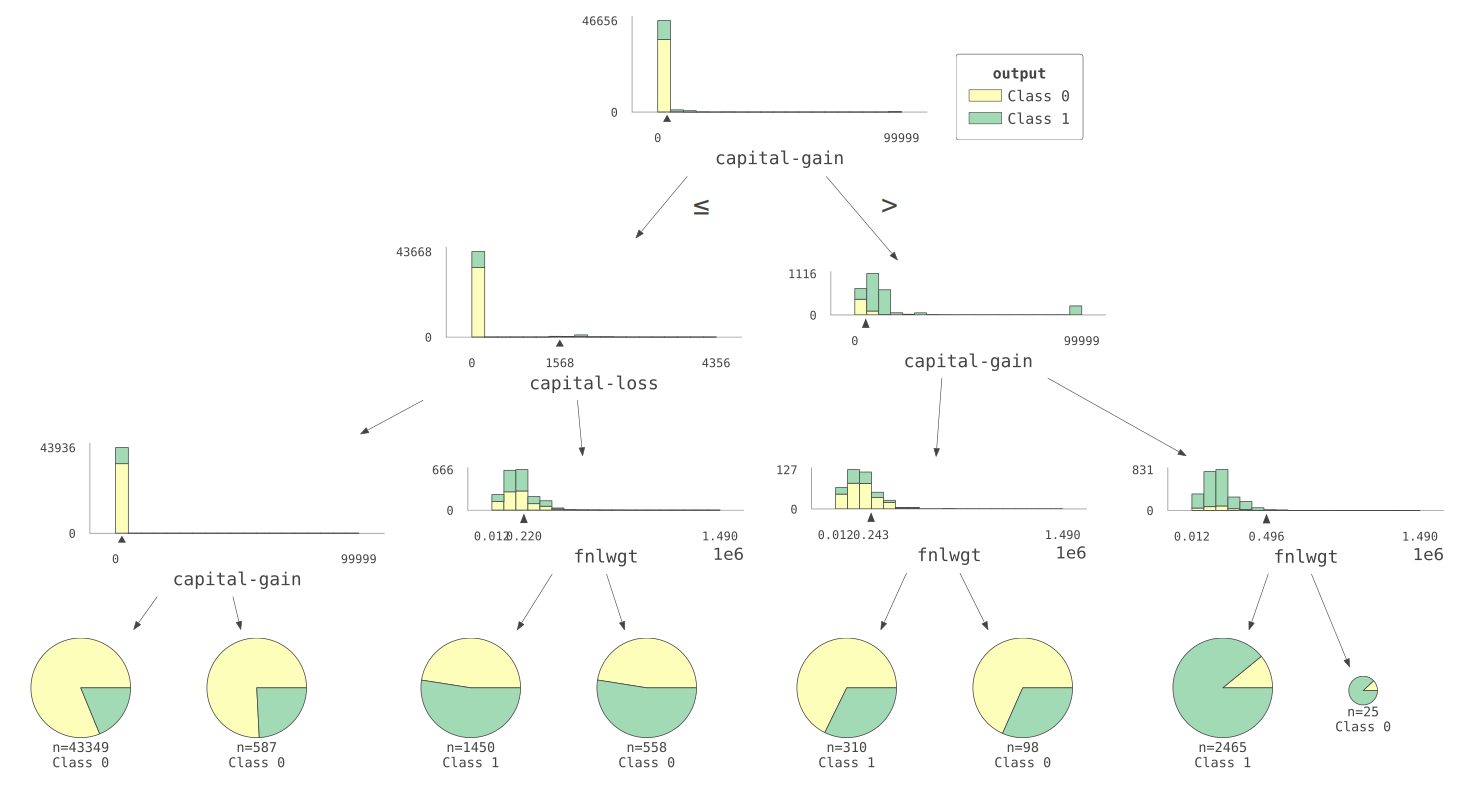

In [21]:
vis = surrogate_explainer.tree_visualization('dtreeviz', scale=2)
vis

# Local Explainability Metrics (based on Lime)

In [22]:
# lime feature importance
lime_explainer = Explainer(based_on='feature_importance',
                      strategy_type='lime',
                      model_type='binary_classification',
                      model = model, 
                      x = X, 
                      y = y)

In [23]:
lime_explainer.metrics(detailed=False)

,Value,Reference
Dataset Stability Gini,0.042734,0
Dataset Stability Mean,0.654796,0
Dataset Stability Ratio,0.999534,1
Features Stability Gini,0.040916,0
Features Stability Mean,0.779941,0
Features Stability Ratio,0.999339,1


In [24]:
lime_explainer.metrics(detailed=True)

,Value,Reference
Metric,,
Dataset Stability Gini,0.042734,0
Dataset Stability Gini [label=0],0.041584,0
Dataset Stability Gini [label=1],0.043758,0
Dataset Stability Mean,0.654796,0
Dataset Stability Mean [label=0],0.657022,0
Dataset Stability Mean [label=1],0.652570,0
Dataset Stability Ratio,0.999534,1
Dataset Stability Ratio [label=0],0.999501,1
Dataset Stability Ratio [label=1],0.999465,1


In [25]:
lime_explainer['Dataset Stability Gini']

0.04273429331551669

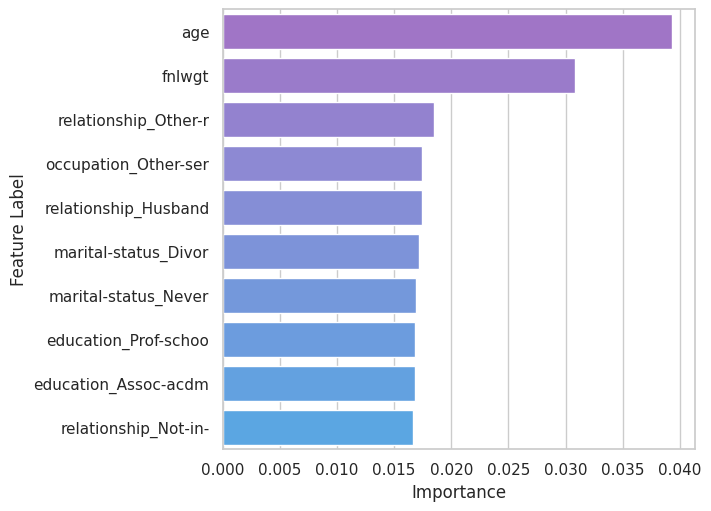

In [26]:
lime_explainer.bar_plot(max_display=10)

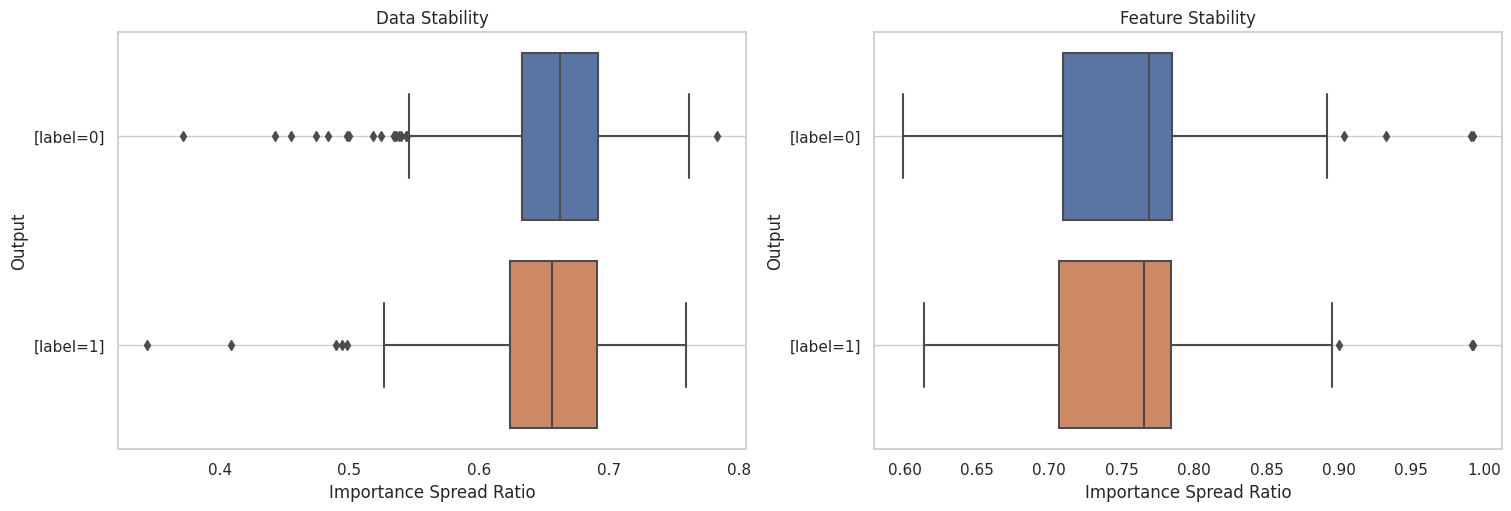

In [27]:
lime_explainer.show_importance_stability()

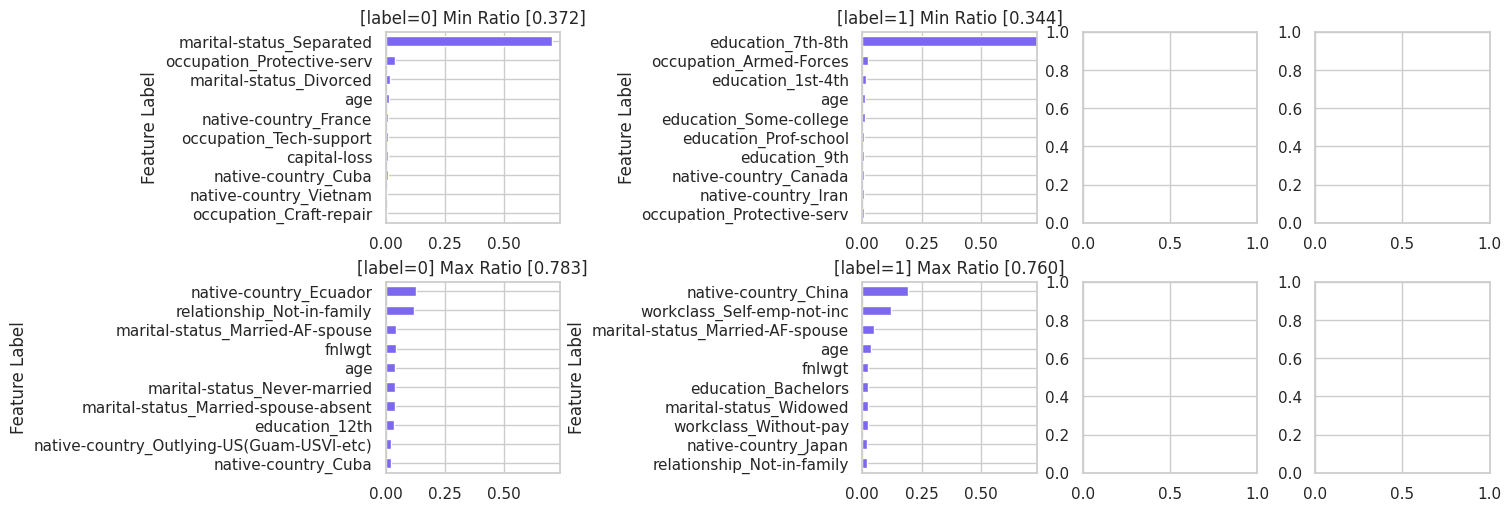

In [28]:
lime_explainer.show_data_stability_boundaries(top_n=10, figsize=(15,5))

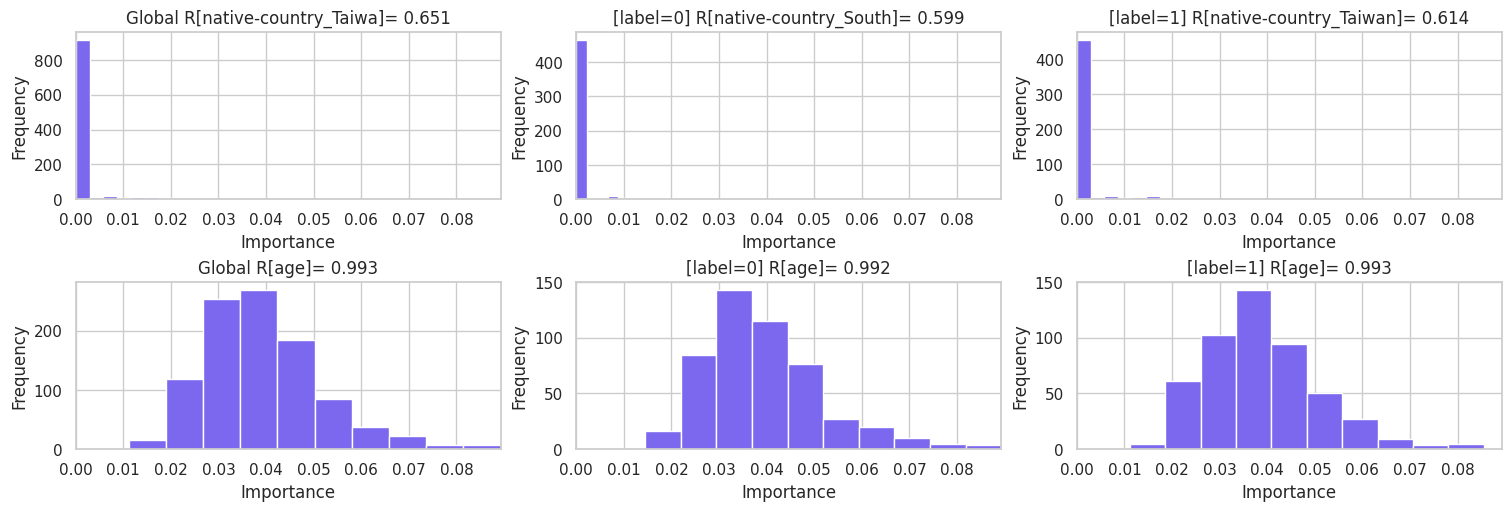

In [29]:
lime_explainer.show_features_stability_boundaries(figsize=(15,5))

# Local Explainability Metrics (SHAP)

In [30]:
# lime feature importance
shap_explainer = Explainer(based_on='feature_importance',
                      strategy_type='shap',
                      model_type='binary_classification',
                      model = model, 
                      x = X, 
                      y = y)

Permutation explainer: 1001it [00:38, 18.58it/s]                          


In [31]:
shap_explainer.metrics(detailed=False)

,Value,Reference
Dataset Stability Gini,0.127153,0
Dataset Stability Mean,0.206077,0
Dataset Stability Ratio,0.993628,1
Features Stability Gini,0.138028,0
Features Stability Mean,0.859924,0
Features Stability Ratio,0.976900,1


In [32]:
shap_explainer['Dataset Stability Gini']

0.12715279575177182

In [33]:
shap_explainer.metrics(detailed=True)

,Value,Reference
Metric,,
Dataset Stability Gini,0.127153,0
Dataset Stability Gini [label=0],0.071978,0
Dataset Stability Gini [label=1],0.179153,0
Dataset Stability Mean,0.206077,0
Dataset Stability Mean [label=0],0.220780,0
Dataset Stability Mean [label=1],0.191373,0
Dataset Stability Ratio,0.993628,1
Dataset Stability Ratio [label=0],0.998376,1
Dataset Stability Ratio [label=1],0.987501,1


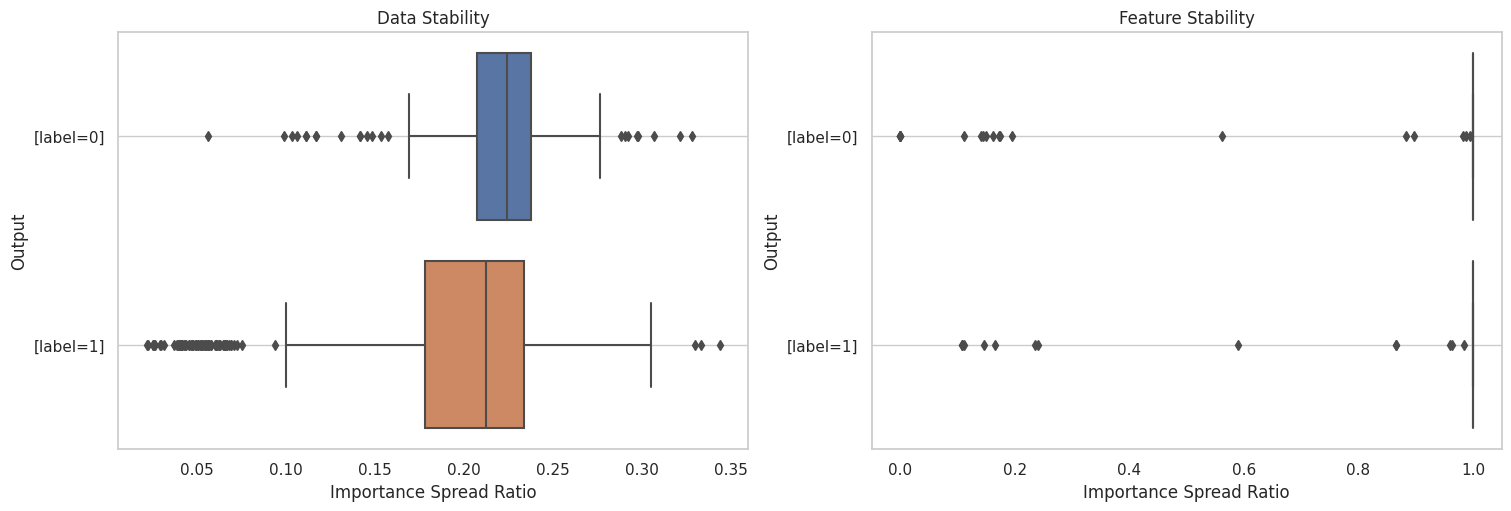

In [34]:
shap_explainer.show_importance_stability()

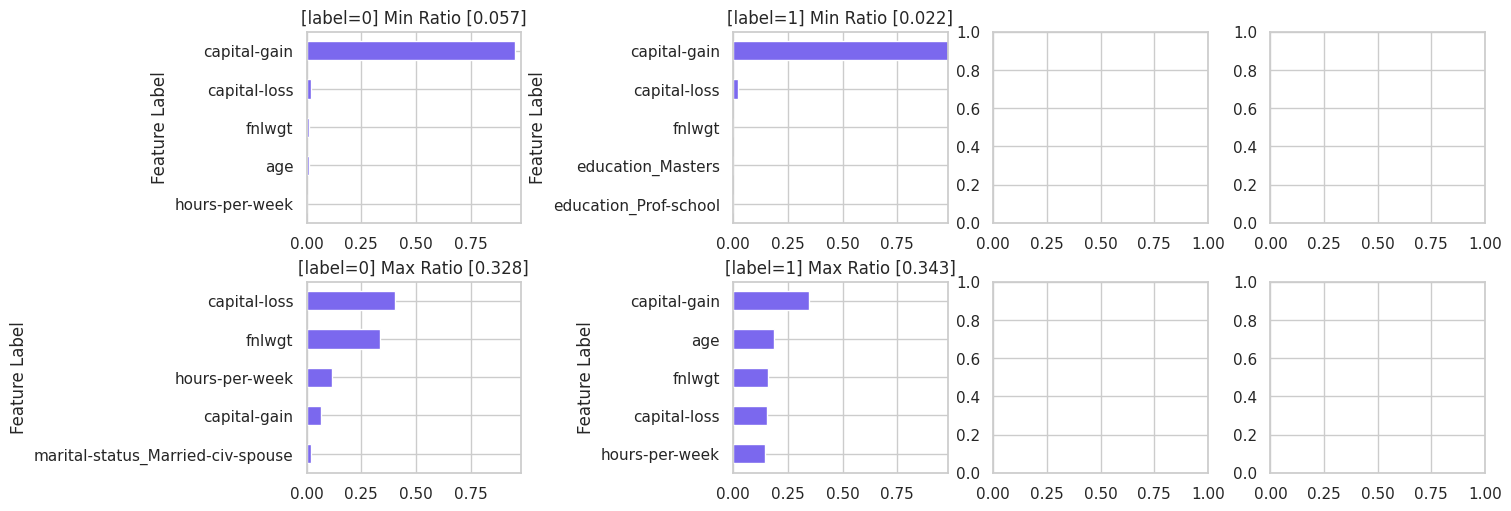

In [35]:
shap_explainer.show_data_stability_boundaries(top_n=5, figsize=(15,5))

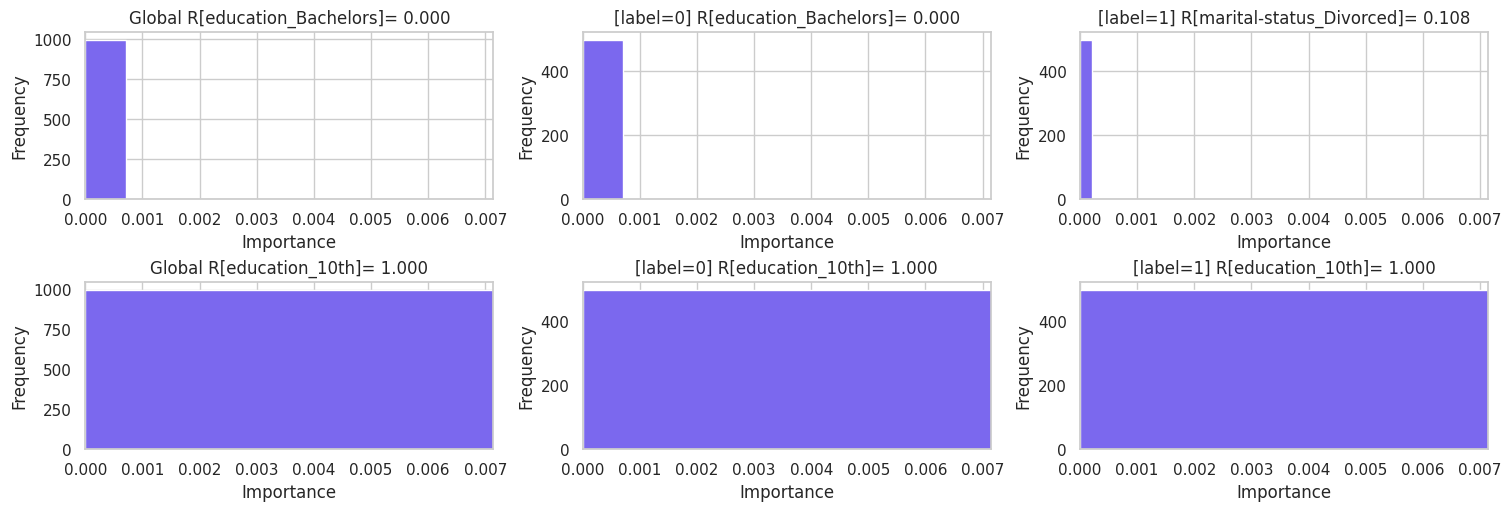

In [36]:
shap_explainer.show_features_stability_boundaries(figsize=(15,5))